# LightGCN

In [1]:
import torch
import torch.nn as nn 

## Data

In [2]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
users_train, items_train, ratings_train, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="explicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="explicit"
) # test_candidates is a dict of {user: [items]}

In [3]:
user_dim = torch.LongTensor(users_train)
item_dim = torch.LongTensor(items_train)
first_sub = torch.stack([user_dim, item_dim + num_users])
second_sub = torch.stack([item_dim + num_users, user_dim])
index = torch.cat([first_sub, second_sub], dim=1)
data = torch.ones(index.size(-1)).int()
Graph = torch.sparse.IntTensor(
    index, data,
    torch.Size([num_users+num_items, num_users+num_items])
)
dense = Graph.to_dense()
"""
A =
    |I,   R|
    |R^T, I|
"""
D = torch.sum(dense, dim=1).float()
D[D==0.] = 1. # avoid dividing by zero
D_sqrt = torch.sqrt(D).unsqueeze(dim=0)
dense = dense/D_sqrt
dense = dense/D_sqrt.t()
"""
A = D^{-1/2} @ A @ D^{-1/2}
"""
index = dense.nonzero()
data  = dense[dense >= 1e-9]
assert len(index) == len(data)
Graph = torch.sparse.FloatTensor(
    index.t(), data,
    torch.Size([num_users+num_items, num_users+num_items])
) # Graph is a symmetric matrix now

/tmp/ipykernel_37556/2863010693.py:7: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  Graph = torch.sparse.IntTensor(


In [4]:
class ML100KPoint(torch.utils.data.Dataset):
    def __init__(self, users, items, ratings):
        assert len(users) == len(items)
        self.users = users
        self.items = items
        self.ratings = ratings

    def __getitem__(self, index):
        return (self.users[index], self.items[index], self.ratings[index])

    def __len__(self):
        return len(self.users)

In [5]:
batch_size = 1024
trainset = ML100KPoint(users_train, items_train, ratings_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
len(train_loader)

98

## Model Config

In [7]:
from gcn.models import LightGCN
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = LightGCN(num_users, num_items, n_factors, Graph.to(device))
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

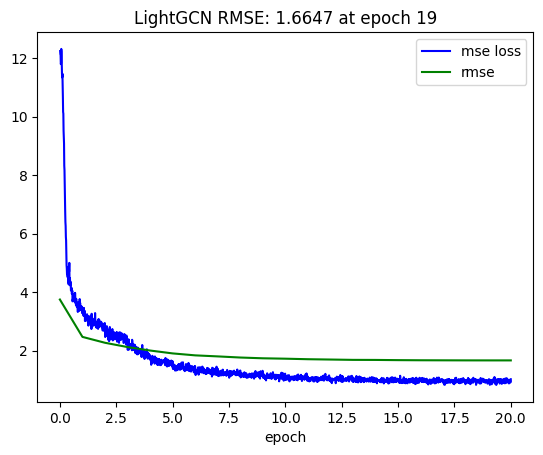

LightGCN RMSE: 1.6647 at epoch 19


In [8]:
from gcn.train import evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []

with torch.no_grad():
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)

    scheduler.step()

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'LightGCN RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'LightGCN RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

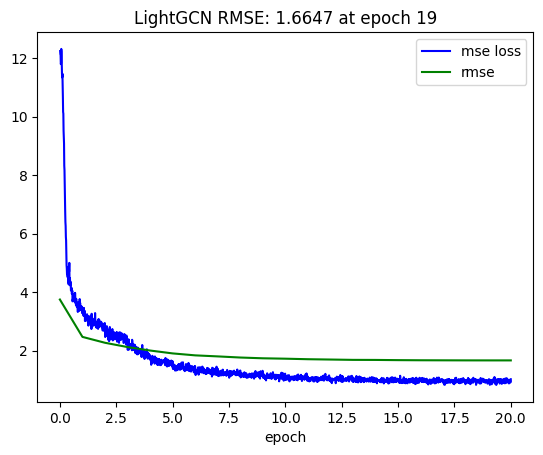

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'LightGCN RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [10]:
rmse_list

[3.745646429154948,
 2.468331893089367,
 2.2673382825288013,
 2.120830709259668,
 2.0023845524078125,
 1.9038697061956618,
 1.8370957637074172,
 1.8015675844913142,
 1.7630445139734712,
 1.7368389875666914,
 1.7232260248333542,
 1.7051673332727346,
 1.6942133702515776,
 1.6828646397637606,
 1.6807273307564088,
 1.6737912328653897,
 1.669451374005016,
 1.667403828994621,
 1.6655991314280185,
 1.6648198942769301,
 1.6647154194255966]

In [11]:
# max(recall_list), min(rmse_list) 
print(f'LightGCN Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

LightGCN Min RMSE: 1.6647 at epoch 20
